In [19]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import EulerSolver, plot_2d_slice, plot_timeseries
from superfv.initial_conditions import square

In [20]:
N = 64
T = 0.01

configs = {
    "ZS3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        ZS=True,
        GL=True,
        include_corners=True,
        PAD={"rho": (0, None), "P": (0, None)},
    ),
    "MM3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        MOOD=True,
        limiting_vars="actives",
        cascade="muscl",
        MUSCL_limiter="PP2D",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        include_corners=True,
        PAD={"rho": (0, None), "P": (0, None)},
    ),
}

In [ ]:
sims = {}
for name, config in configs.items():
    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=partial(square, bounds=(1e-5, 1), vx=2, vy=1, P=1e-5),
        nx=N,
        ny=N,
        **config,
    )

    try:
        sim.run(
            T,
            q_max=2,
            allow_overshoot=True,
            log_freq=20,
        )
        sims[name] = sim
    except RuntimeError as e:
        print(f"Simulation '{name}' failed: {e}")

Running simulation: ZS3
Step #5 @ t=1.16e-02 | dt=2.33e-03 | min(rho)=1.00e-05, min(P)=1.00e-05 | (done)                    
Running simulation: MM3
Step #8 @ t=1.06e-02 | dt=1.37e-03 | min(rho)=-2.58e-05, min(P)=1.00e-05 | (done)                   


(<matplotlib.image.AxesImage at 0x11f5b7860>,
 <matplotlib.colorbar.Colorbar at 0x11fa3bbf0>)

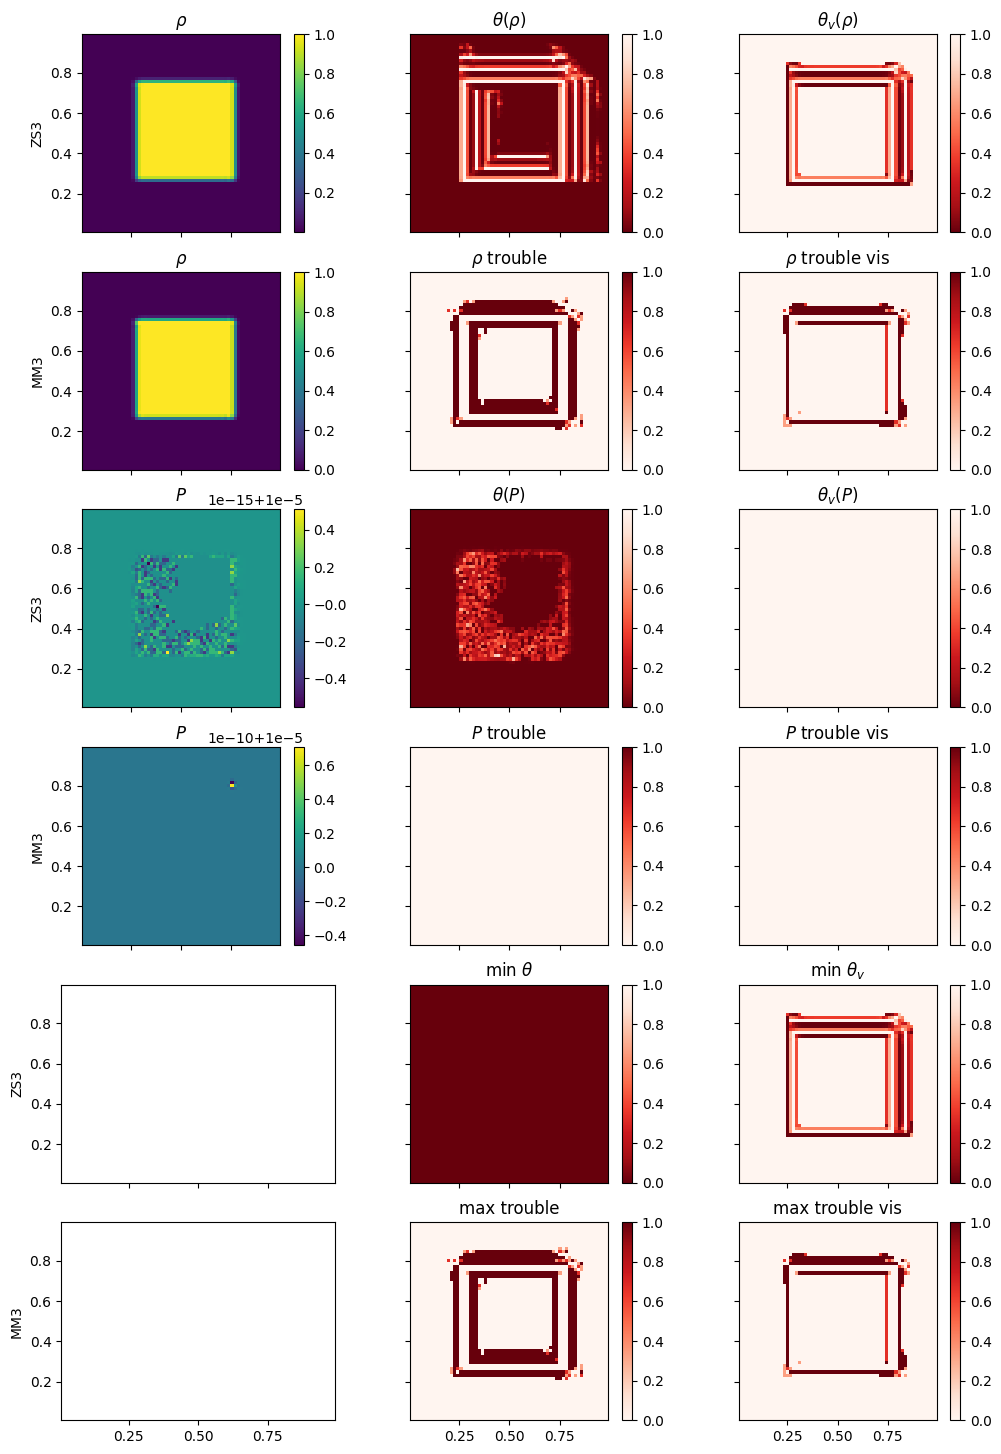

In [22]:
sim1 = sims["ZS3"]
sim2 = sims["MM3"]

fig, axs = plt.subplots(6, 3, sharex=True, sharey=True, figsize=(12, 18))

axs[0, 0].set_ylabel("ZS3")
axs[0, 0].set_title(r"$\rho$")
axs[0, 1].set_title(r"$\theta(\rho)$")
axs[0, 2].set_title(r"$\theta_v(\rho)$")

axs[1, 0].set_ylabel("MM3")
axs[1, 0].set_title(r"$\rho$")
axs[1, 1].set_title(r"$\rho$ trouble")
axs[1, 2].set_title(r"$\rho$ trouble vis")

axs[2, 0].set_ylabel("ZS3")
axs[2, 0].set_title(r"$P$")
axs[2, 1].set_title(r"$\theta(P)$")
axs[2, 2].set_title(r"$\theta_v(P)$")

axs[3, 0].set_ylabel("MM3")
axs[3, 0].set_title(r"$P$")
axs[3, 1].set_title(r"$P$ trouble")
axs[3, 2].set_title(r"$P$ trouble vis")

axs[4, 0].set_ylabel("ZS3")
axs[4, 1].set_title(r"min $\theta$")
axs[4, 2].set_title(r"min $\theta_v$")

axs[5, 0].set_ylabel("MM3")
axs[5, 1].set_title(r"max trouble")
axs[5, 2].set_title(r"max trouble vis")


style = dict(cell_averaged=True, colorbar=True)
theta_style = dict(theta=True, cmap="Reds_r", vmin=0, vmax=1, colorbar=True)
trouble_style = dict(troubles=True, cmap="Reds", vmin=0, vmax=1, colorbar=True)

plot_2d_slice(sim1, axs[0, 0], "rho", **style)
plot_2d_slice(sim1, axs[0, 1], "rho", visualization=False, **theta_style)
plot_2d_slice(sim1, axs[0, 2], "rho", visualization=True, **theta_style)

plot_2d_slice(sim2, axs[1, 0], "rho", **style)
plot_2d_slice(sim2, axs[1, 1], "rho", visualization=False, **trouble_style)
plot_2d_slice(sim2, axs[1, 2], "rho", visualization=True, **trouble_style)

plot_2d_slice(sim1, axs[2, 0], "P", **style)
plot_2d_slice(sim1, axs[2, 1], "P", visualization=False, **theta_style)
plot_2d_slice(sim1, axs[2, 2], "P", visualization=True, **theta_style)

plot_2d_slice(sim2, axs[3, 0], "P", **style)
plot_2d_slice(sim2, axs[3, 1], "P", visualization=False, **trouble_style)
plot_2d_slice(sim2, axs[3, 2], "P", visualization=True, **trouble_style)

plot_2d_slice(sim1, axs[4, 1], "min", visualization=False, **theta_style)
plot_2d_slice(sim1, axs[4, 2], "min", visualization=True, **theta_style)

plot_2d_slice(sim2, axs[5, 1], "max", visualization=False, **trouble_style)
plot_2d_slice(sim2, axs[5, 2], "max", visualization=True, **trouble_style)

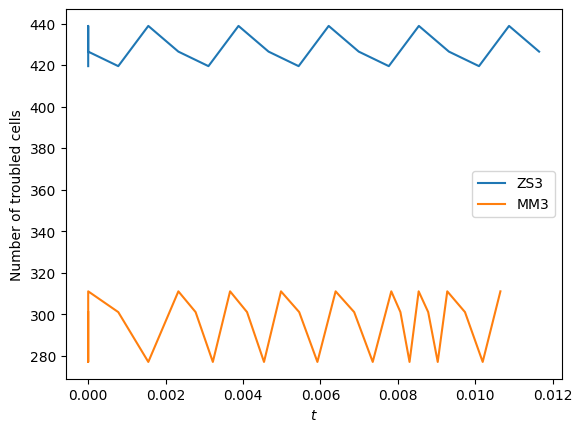

In [23]:
fig, ax = plt.subplots()
ax.set_ylabel("Number of troubled cells")
ax.set_xlabel(r"$t$")

plot_timeseries(sims["ZS3"], ax, "nfine_1-theta_vis_max", label="ZS3")
plot_timeseries(sims["MM3"], ax, "nfine_troubles_vis_max", label="MM3")

ax.legend()

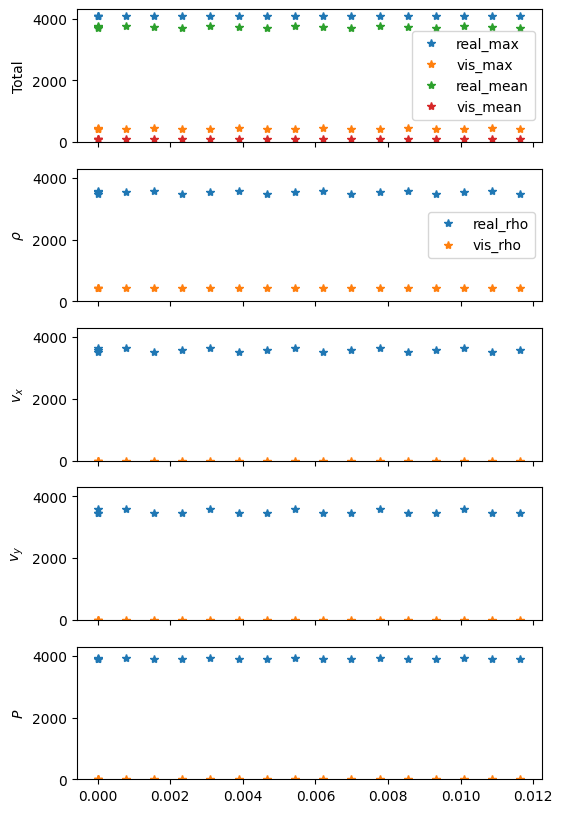

In [24]:
fig, axs = plt.subplots(5, 1, sharex=True, sharey=True, figsize=(6, 10))
axs[0].set_ylim(0, 1.05 * N**2)
axs[0].set_ylabel("Total")
axs[1].set_ylabel(r"$\rho$")
axs[2].set_ylabel(r"$v_x$")
axs[3].set_ylabel(r"$v_y$")
axs[4].set_ylabel(r"$P$")

sim = sims["ZS3"]
style = dict(marker="*", linestyle="none")

plot_timeseries(sim, axs[0], "nfine_1-theta_real_max", label="real_max", **style)
plot_timeseries(sim, axs[0], "nfine_1-theta_vis_max", label="vis_max", **style)
plot_timeseries(sim, axs[0], "nfine_1-theta_real_mean", label="real_mean", **style)
plot_timeseries(sim, axs[0], "nfine_1-theta_vis_mean", label="vis_mean", **style)

plot_timeseries(sim, axs[1], "nfine_1-theta_real_rho", label="real_rho", **style)
plot_timeseries(sim, axs[1], "nfine_1-theta_vis_rho", label="vis_rho", **style)

plot_timeseries(sim, axs[2], "nfine_1-theta_real_vx", label="real_vx", **style)
plot_timeseries(sim, axs[2], "nfine_1-theta_vis_vx", label="vis_vx", **style)

plot_timeseries(sim, axs[3], "nfine_1-theta_real_vy", label="real_vy", **style)
plot_timeseries(sim, axs[3], "nfine_1-theta_vis_vy", label="vis_vy", **style)

plot_timeseries(sim, axs[4], "nfine_1-theta_real_P", label="real_P", **style)
plot_timeseries(sim, axs[4], "nfine_1-theta_vis_P", label="vis_P", **style)

axs[0].legend()
axs[1].legend()